In [1]:
import os
os.chdir("/home/mohsen/projects/scarches/")

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import scanpy as sc
import scarches as sca
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsTransformer, DistanceMetric

Using TensorFlow backend.


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
sc.settings.set_figure_params(dpi=100)
sc.settings.figdir = "./results/integration/HCL_MCA/"

In [6]:
condition_key = "species_stage"
cell_type_key = 'celltype'
target_conditions = ["Mice - Adult", 'Mice - Fetal', 'Mice - Neonatal']

# Loading Tabula Senis datasets and data preparation

In [7]:
adata = sc.read("/home/mohsen/data/hcl/hcl_mca_orth_1e4_species_age.h5ad")
adata

AnnData object with n_obs × n_vars = 372789 × 5000 
    obs: 'cellnames', 'cluster', 'tissue', 'stage', 'celltype', 'species', 'sample', 'batch', 'donor', 'species_age', 'n_counts', 'refined_tissue', 'age', 'species_stage'

In [8]:
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
source_adata

View of AnnData object with n_obs × n_vars = 249845 × 5000 
    obs: 'cellnames', 'cluster', 'tissue', 'stage', 'celltype', 'species', 'sample', 'batch', 'donor', 'species_age', 'n_counts', 'refined_tissue', 'age', 'species_stage'

In [9]:
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
target_adata

View of AnnData object with n_obs × n_vars = 122944 × 5000 
    obs: 'cellnames', 'cluster', 'tissue', 'stage', 'celltype', 'species', 'sample', 'batch', 'donor', 'species_age', 'n_counts', 'refined_tissue', 'age', 'species_stage'

In [10]:
source_adata.obs[condition_key].value_counts()

Human - Adult       154812
Human - Fetal        92326
Human - Neonatal      2707
Name: species_stage, dtype: int64

In [11]:
target_adata.obs[condition_key].value_counts()

Mice - Adult       63552
Mice - Fetal       36524
Mice - Neonatal    22868
Name: species_stage, dtype: int64

In [12]:
conditions = source_adata.obs[condition_key].unique().tolist()
conditions

['Human - Adult', 'Human - Fetal', 'Human - Neonatal']

# Create & Train model with training data

In [15]:
network = sca.models.scArches(task_name='HCL',
                              x_dimension=source_adata.shape[1], 
                              z_dimension=40,
                              architecture=[128, 20],
                              gene_names=source_adata.var_names.tolist(),
                              conditions=conditions,
                              use_batchnorm=False,
                              lr=0.001,
                              alpha=0.0001,
                              beta=30,
                              eta=1000,
                              clip_value=10,
                              loss_fn='mse',
                              mmd_computation_method='general',
                              model_path="./models/CVAE/hcl_mca_orth_species_age/",
                              dropout_rate=0.05,
                              output_activation='relu')

W0726 15:41:42.990262 140142087599936 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0726 15:41:42.993386 140142087599936 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0726 15:41:42.994604 140142087599936 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0726 15:41:43.384388 140142087599936 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf

scArches' network has been successfully constructed!


W0726 15:41:43.999027 140142087599936 module_wrapper.py:139] From /home/mohsen/projects/scarches/scarches/models/_utils.py:84: The name tf.is_nan is deprecated. Please use tf.math.is_nan instead.

W0726 15:41:44.001989 140142087599936 deprecation.py:323] From /home/mohsen/projects/scarches/scarches/models/_utils.py:84: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


scArches' network has been successfully compiled!


## Training the network

In [ ]:
network.train(source_adata,
              train_size=0.8, 
              condition_key=condition_key,
              n_epochs=1000,
              batch_size=512, 
              early_stop_limit=30,
              lr_reducer=20, 
              save=True, 
              retrain=False,
              verbose=5)

Instructions for updating:
Use tf.cast instead.
 |████----------------| 23.8%  - loss: 73.5971 - reconstruction_loss: 69.8854 - mmd_loss: 3.7117 - val_loss: 72.4883 - val_reconstruction_loss: 68.0446 - val_mmd_loss: 4.4438

In [25]:
network.condition_encoder

{'Human - Adult': 0, 'Human - Fetal': 1, 'Human - Neonatal': 2}

In [26]:
plot_adata = sc.pp.subsample(source_adata, n_obs=50000, copy=True)

In [28]:
latent_adata = network.get_latent(plot_adata, condition_key, return_z=False)
latent_adata

AnnData object with n_obs × n_vars = 50000 × 20 
    obs: 'cellnames', 'cluster', 'tissue', 'stage', 'celltype', 'species', 'sample', 'batch', 'donor', 'species_age', 'n_counts', 'refined_tissue', 'age', 'species_stage'

In [29]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [32]:
latent_adata.write_h5ad("/home/mohsen/data/hcl/latents/species_age/pretrain.h5ad")

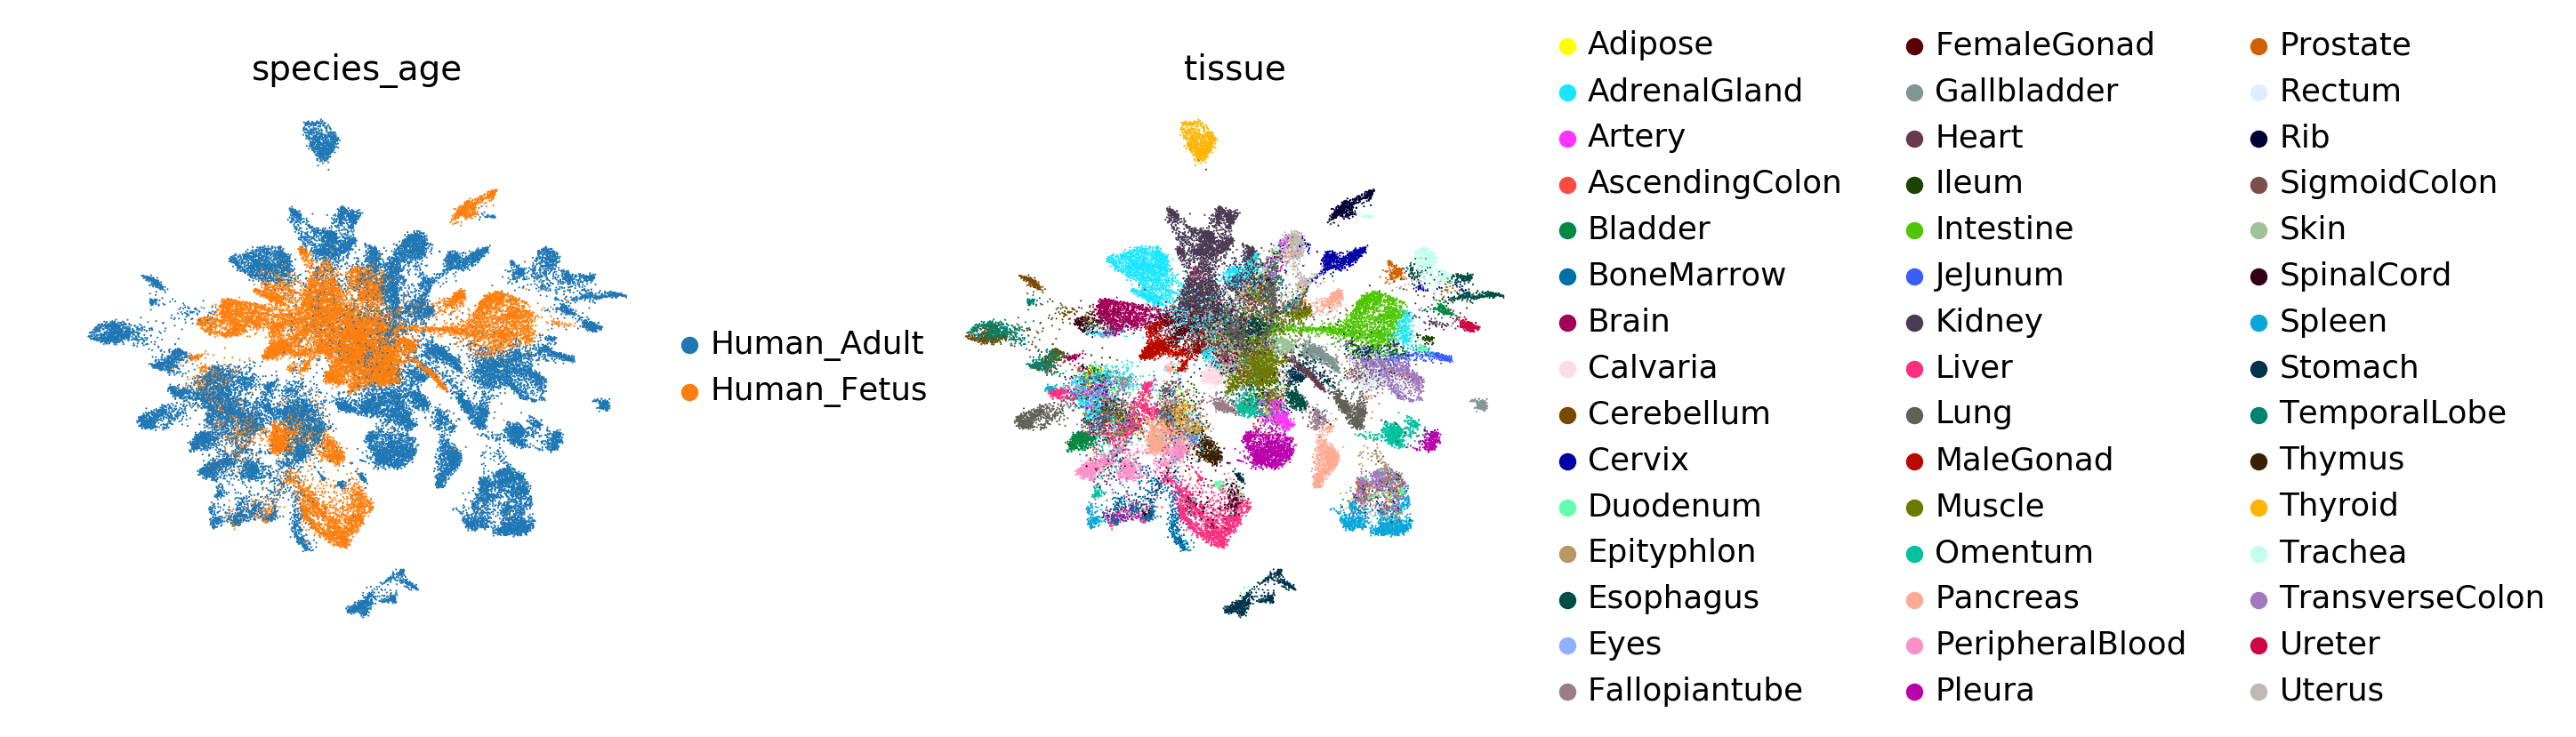

In [30]:
sc.pl.umap(latent_adata, color=['species_age', 'tissue'], wspace=0.35, frameon=False)

# Perfroming architecture Surgery

In [ ]:
new_network = sca.operate(network,
                          new_task_name='HCL_MCA',
                          new_conditions=target_conditions,
                          init='Xavier', 
                          version='scArches v1',
                          remove_dropout=False,
                          new_training_kwargs={"beta": 50},
                          )

In [34]:
new_network.condition_encoder

{'Human - Adult': 0,
 'Human - Fetal': 1,
 'Human - Neonatal': 2,
 'Mice - Adult': 3,
 'Mice - Fetal': 4,
 'Mice - Neonatal': 5}

## Train with small new dataset containing out-of-sample condition

In [38]:
new_network.train(target_adata,
                  train_size=0.8, 
                  condition_key=condition_key,
                  n_epochs=1000,
                  batch_size=512, 
                  early_stop_limit=30,
                  lr_reducer=20, 
                  save=True,
                  retrain=True)

 |██████--------------| 31.6%  - loss: 77.7055 - reconstruction_loss: 76.9291 - mmd_loss: 0.7764 - val_loss: 76.0232 - val_reconstruction_loss: 75.1969 - val_mmd_loss: 0.8263.7223

In [40]:
latent_adata = new_network.get_latent(target_adata, condition_key, return_z=False)
latent_adata

AnnData object with n_obs × n_vars = 122944 × 20 
    obs: 'cellnames', 'cluster', 'tissue', 'stage', 'celltype', 'species', 'sample', 'batch', 'donor', 'species_age', 'n_counts', 'refined_tissue', 'age', 'species_stage'

In [42]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [44]:
latent_adata.write_h5ad("/home/mohsen/data/hcl/latents/species_age/mca.h5ad")

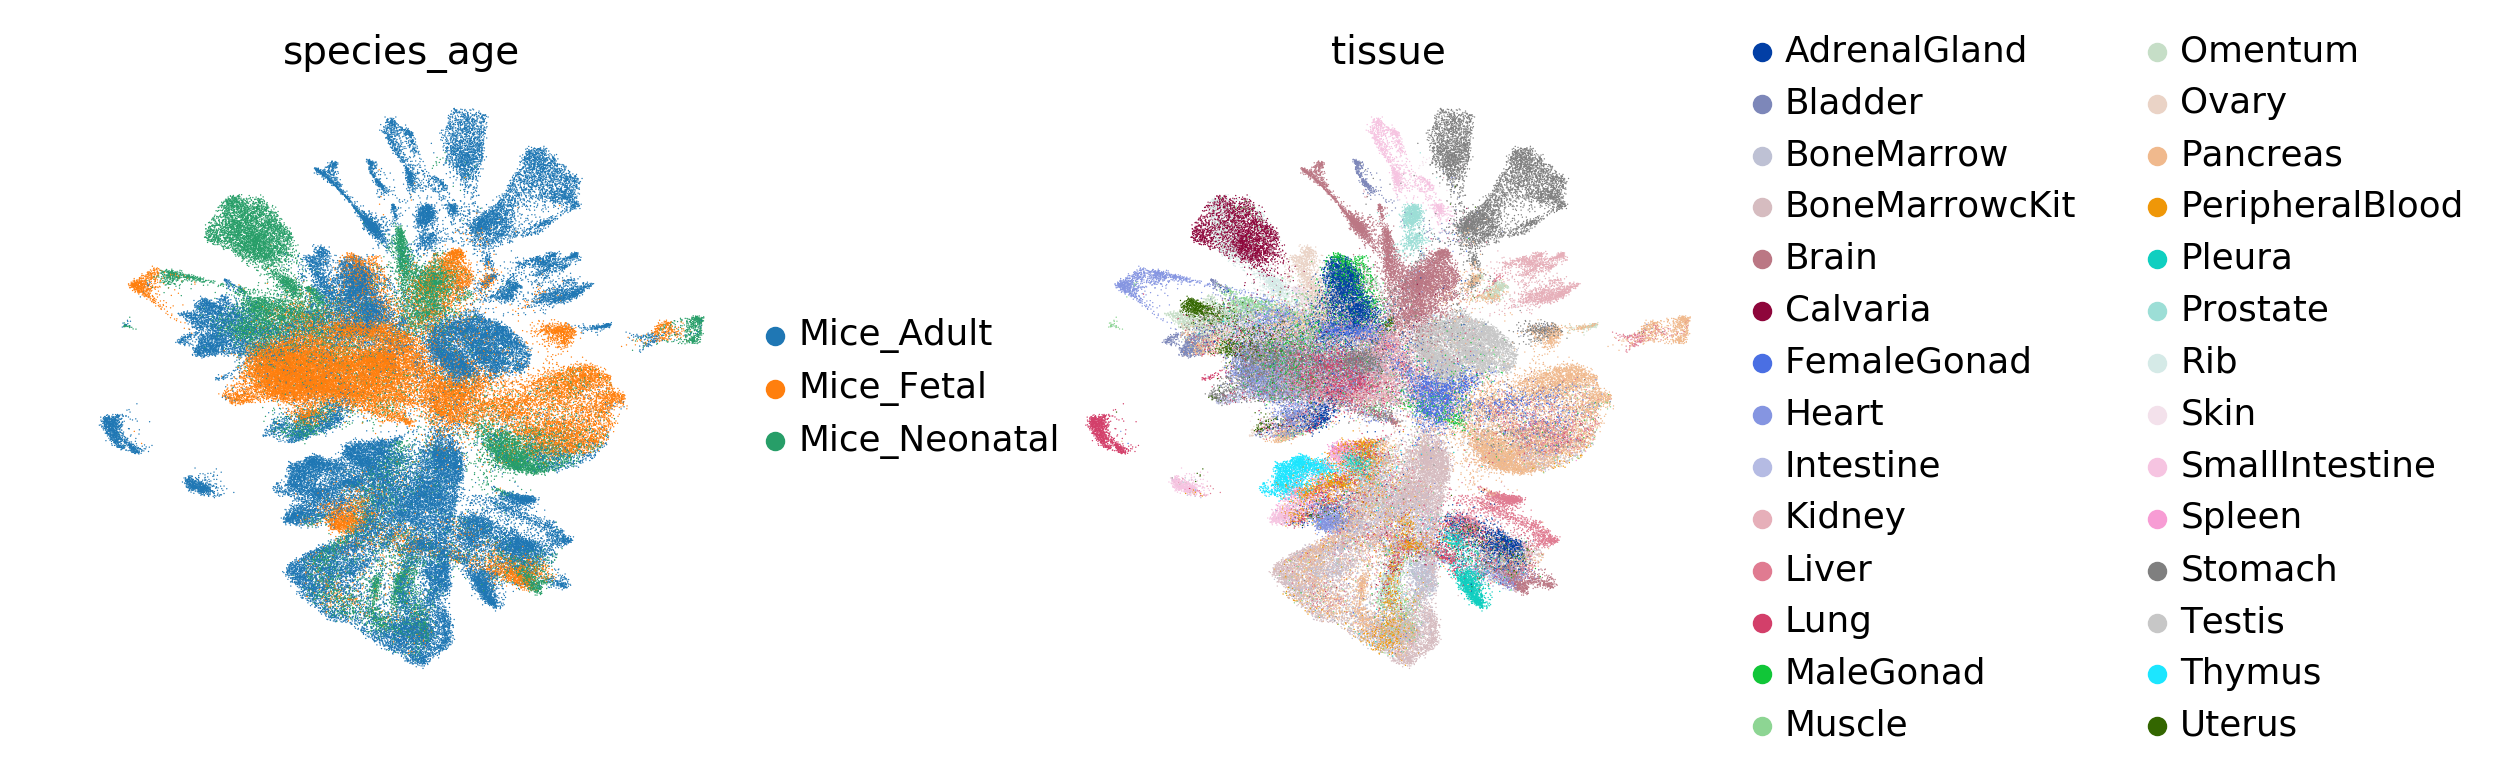

In [45]:
sc.pl.umap(latent_adata, color=['species_age', 'tissue'], wspace=0.35, frameon=False)

In [48]:
source_subsampled = sc.pp.subsample(source_adata, n_obs=160000, copy=True)

In [49]:
plot_adata = source_subsampled.concatenate(target_adata)

In [51]:
latent_adata = new_network.get_latent(plot_adata, condition_key, return_z=False)
latent_adata

AnnData object with n_obs × n_vars = 282944 × 20 
    obs: 'age', 'batch', 'cellnames', 'celltype', 'cluster', 'donor', 'n_counts', 'refined_tissue', 'sample', 'species', 'species_age', 'species_stage', 'stage', 'tissue'

In [52]:
latent_adata.obs['species'].value_counts()

Human    160000
Mice     122944
Name: species, dtype: int64

In [53]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

... storing 'cellnames' as categorical
... storing 'celltype' as categorical
... storing 'donor' as categorical
... storing 'refined_tissue' as categorical
... storing 'sample' as categorical
... storing 'species' as categorical
... storing 'species_age' as categorical
... storing 'species_stage' as categorical
... storing 'stage' as categorical
... storing 'tissue' as categorical


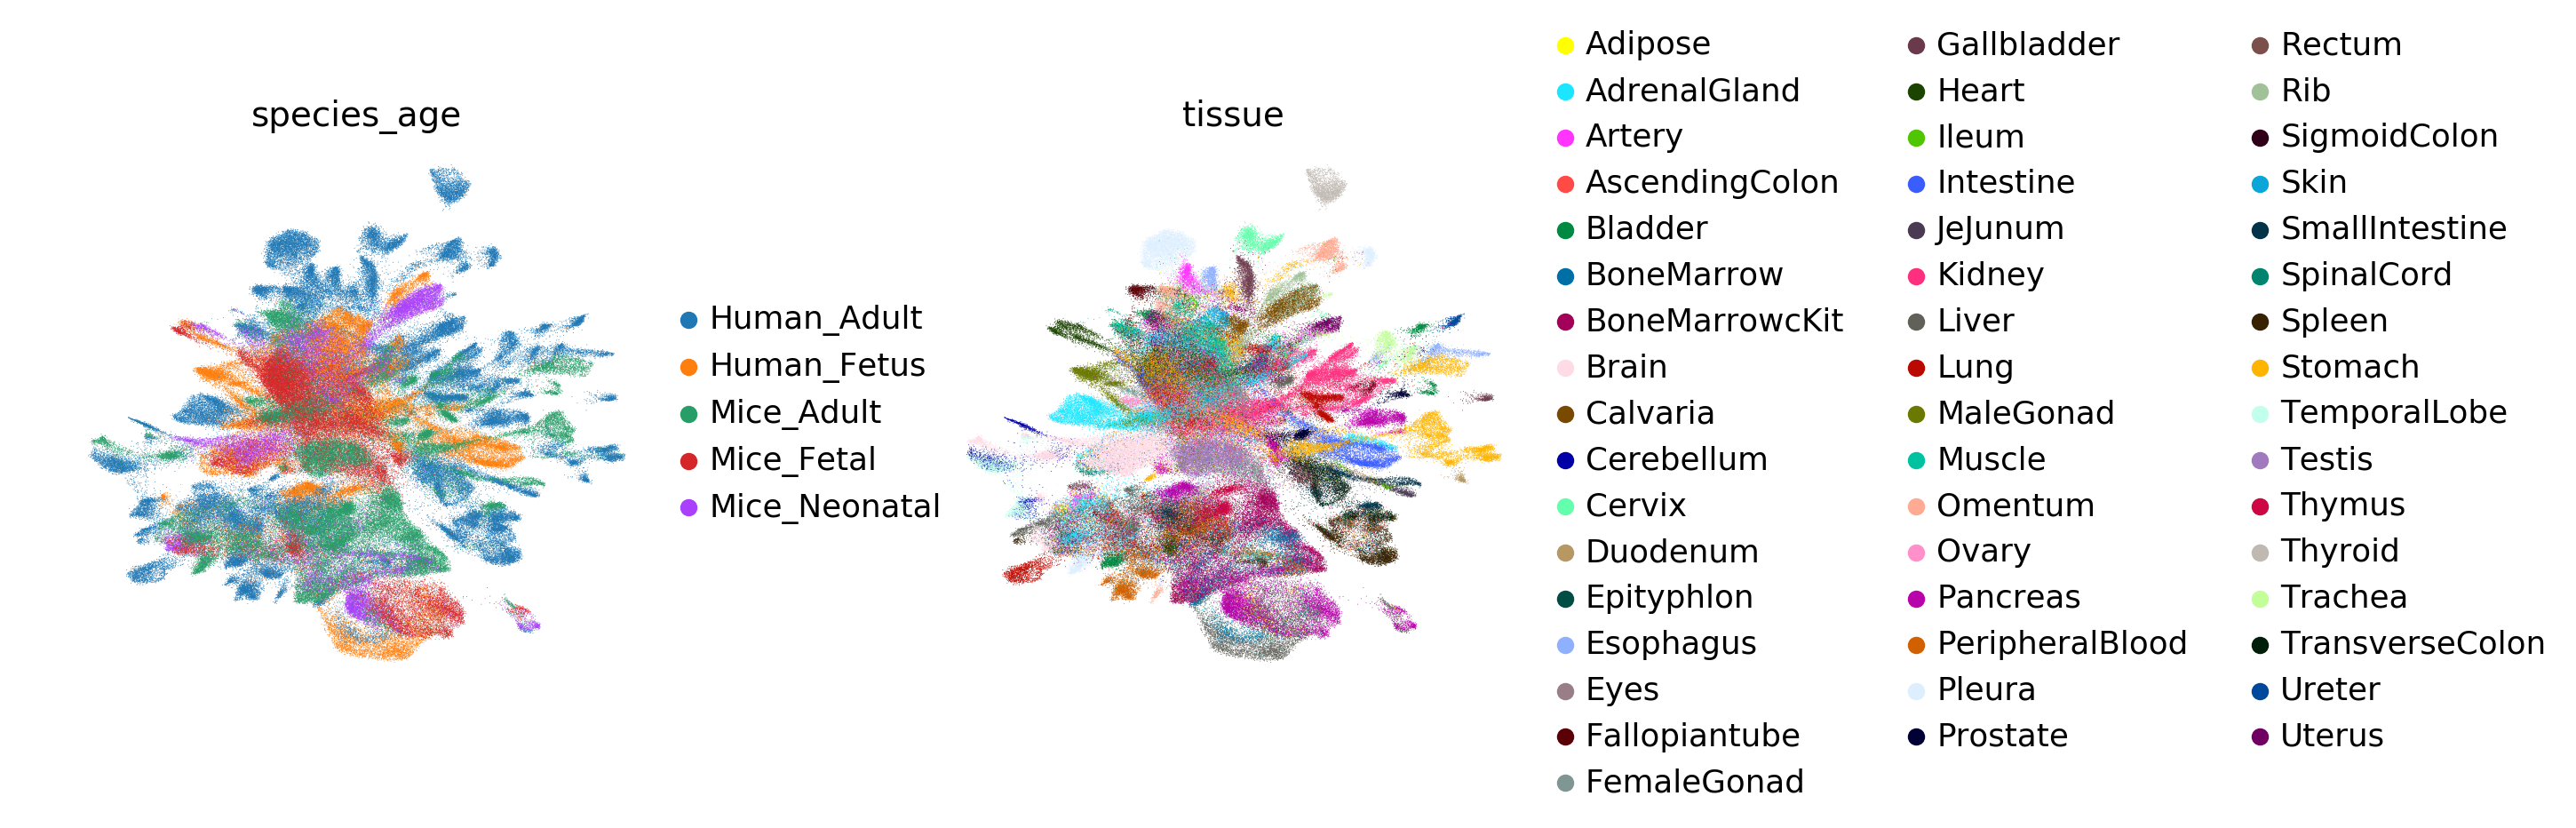

In [54]:
sc.pl.umap(latent_adata, color=['species_age', 'tissue'], wspace=0.35, frameon=False)

In [57]:
latent_adata.write_h5ad("/home/mohsen/data/hcl/latents/species_age/hcl+mca.h5ad")